In [2]:
# Install required libraries
!pip install prophet xgboost scikit-learn statsmodels pandas requests matplotlib

   ---------------------------------------- 0.0/12.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.1 MB ? eta -:--:--
    --------------------------------------- 0.3/12.1 MB ? eta -:--:--
   -- ------------------------------------- 0.8/12.1 MB 1.7 MB/s eta 0:00:07
   ---- ----------------------------------- 1.3/12.1 MB 2.1 MB/s eta 0:00:06
   ------- -------------------------------- 2.4/12.1 MB 2.8 MB/s eta 0:00:04
   ----------- ---------------------------- 3.4/12.1 MB 3.3 MB/s eta 0:00:03
   ------------- -------------------------- 4.2/12.1 MB 3.5 MB/s eta 0:00:03
   -------------- ------------------------- 4.5/12.1 MB 3.5 MB/s eta 0:00:03
   -------------- ------------------------- 4.5/12.1 MB 3.5 MB/s eta 0:00:03
   ---------------- ----------------------- 5.0/12.1 MB 2.7 MB/s eta 0:00:03
   ----------------- ---------------------- 5.2/12.1 MB 2.5 MB/s eta 0:00:03
   ----------------- ------

C:\Users\azlan\AppData\Local\Temp\ipykernel_5284\3479158499.py:21: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv('household_power_consumption.txt', sep=';',
C:\Users\azlan\AppData\Local\Temp\ipykernel_5284\3479158499.py:21: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('household_power_consumption.txt', sep=';',
C:\Users\azlan\AppData\Local\Temp\ipykernel_5284\3479158499.py:31: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_hourly = series.resample('H').mean().fillna(method='ffill')
C:\Users\azlan\AppData\Local\Temp\ipykernel_5284\3479158499.py:31: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill()

Training on 34421 hours, Testing on 168 hours.


00:57:45 - cmdstanpy - INFO - Chain [1] start processing
00:57:55 - cmdstanpy - INFO - Chain [1] done processing
C:\anaconda\Lib\site-packages\prophet\forecaster.py:1875: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(



Results (RMSE):
ARIMA: 0.9480
Prophet: 0.7555
XGBoost: 0.7053


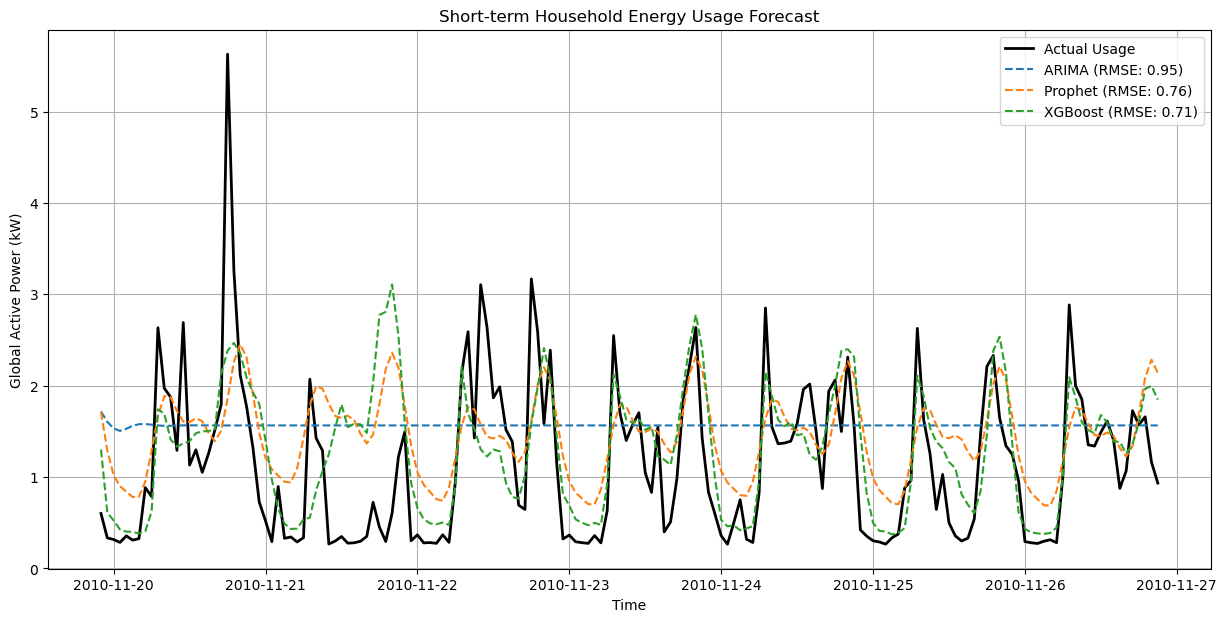

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests, zipfile, io
from datetime import datetime

# Models
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# --- STEP 1: DATA ACQUISITION ---
print("Downloading dataset...")
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip"
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

# Load data: ';' separator, handle '?' as NaNs, parse Date/Time
df = pd.read_csv('household_power_consumption.txt', sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, 
                 low_memory=False, na_values=['?'], index_col='dt')

# Drop missing values and select target column
df.dropna(inplace=True)
series = df['Global_active_power']

# --- STEP 2: RESAMPLING & FEATURE ENGINEERING ---
# Resample to Hourly to capture daily cycles without excessive noise
data_hourly = series.resample('H').mean().fillna(method='ffill')

def create_time_features(df):
    temp_df = pd.DataFrame(df)
    temp_df['hour'] = temp_df.index.hour
    temp_df['dayofweek'] = temp_df.index.dayofweek
    temp_df['month'] = temp_df.index.month
    temp_df['is_weekend'] = (temp_df.index.dayofweek >= 5).astype(int)
    return temp_df

features_df = create_time_features(data_hourly)

# Train/Test Split: Use the last 7 days (168 hours) for testing
test_hours = 24 * 7
train = features_df.iloc[:-test_hours]
test = features_df.iloc[-test_hours:]

print(f"Training on {len(train)} hours, Testing on {len(test)} hours.")

# --- STEP 3: MODELING ---

# A. ARIMA (Statistical)
# Note: Using simple parameters for speed; (5,1,0) is a common starting point
model_arima = ARIMA(train['Global_active_power'], order=(5,1,0))
arima_result = model_arima.fit()
forecast_arima = arima_result.forecast(steps=test_hours)

# B. Prophet (Structural)
prophet_train = train.reset_index().rename(columns={'dt':'ds', 'Global_active_power':'y'})
model_prophet = Prophet(daily_seasonality=True, weekly_seasonality=True)
model_prophet.fit(prophet_train)
future = model_prophet.make_future_dataframe(periods=test_hours, freq='H')
forecast_prophet = model_prophet.predict(future)
predictions_prophet = forecast_prophet.iloc[-test_hours:]['yhat']

# C. XGBoost (Machine Learning)
X_train, y_train = train.drop('Global_active_power', axis=1), train['Global_active_power']
X_test, y_test = test.drop('Global_active_power', axis=1), test['Global_active_power']

model_xgb = XGBRegressor(n_estimators=500, learning_rate=0.05)
model_xgb.fit(X_train, y_train)
predictions_xgb = model_xgb.predict(X_test)

# --- STEP 4: EVALUATION & VISUALIZATION ---
rmse_arima = np.sqrt(mean_squared_error(y_test, forecast_arima))
rmse_prophet = np.sqrt(mean_squared_error(y_test, predictions_prophet))
rmse_xgb = np.sqrt(mean_squared_error(y_test, predictions_xgb))

print(f"\nResults (RMSE):")
print(f"ARIMA: {rmse_arima:.4f}")
print(f"Prophet: {rmse_prophet:.4f}")
print(f"XGBoost: {rmse_xgb:.4f}")

plt.figure(figsize=(15, 7))
plt.plot(test.index, y_test, label='Actual Usage', color='black', lw=2)
plt.plot(test.index, forecast_arima, label=f'ARIMA (RMSE: {rmse_arima:.2f})', linestyle='--')
plt.plot(test.index, predictions_prophet.values, label=f'Prophet (RMSE: {rmse_prophet:.2f})', linestyle='--')
plt.plot(test.index, predictions_xgb, label=f'XGBoost (RMSE: {rmse_xgb:.2f})', linestyle='--')
plt.title('Short-term Household Energy Usage Forecast')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.grid(True)
plt.show()